In this notebook, we solve an Allen-Cahn equation of the form
$$ \frac{\delta u}{\delta t} = d \frac{\delta^2 u}{\delta x^2} + 5\left( u - u^3 \right)$$

for $x \in [-1, 1]$ and $t \in [0, 1]$, with $d = 0.001$. We consider $t \in [0, 0.5]$ as the interpolation domain and $(0.5, 1]$ as the extrapolation domain. The initial condition is given by
$$ u(x, 0) = x^2 \cos (\pi x)$$

and the boundary condition is defined as
$$ u(-1, t) = u(1, t) = -1$$

In [1]:
# install DeepXDE

%pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.7 MB/s eta 0:00:00


In [2]:
# import packages

import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from deepxde.backend import tf

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



In [18]:
# set up the problem

def gen_testdata():
    data = loadmat("/content/Allen_Cahn.mat")

    t = data["t"]
    x = data["x"]
    u = data["u"]

    dt = dx = 0.01
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = u.flatten()[:, None]
    return X, y

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
d = 0.001

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - d * dy_xx - 5 * (y - y**3)

# define the boundary and initial conditions

def func(x):
    return (x[:, 0:1])**2 * np.cos(np.pi * x[:, 0:1])

bc = dde.icbc.DirichletBC(geomtime, lambda x: -1, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: (x[:, 0:1])**2 * np.cos(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

# Hard restraints on initial + boundary conditions   MIGHT WANT TO TEST THE EFFECT OF THIS ON EXTRAPOLATION BEHVAVIOR
def output_transform(x, y):
   return x[:, 0:1]**2 * tf.cos(np.pi * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1]**2) * y

data = dde.data.TimePDE(geomtime, pde, [], num_domain=8000, num_boundary=400, num_initial=800)

In [22]:
# set up the model

net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")
net.apply_output_transform(output_transform)
model = dde.Model(data, net)

model.compile("adam", lr=1e-4)

Compiling model...
Building feed-forward neural network...
'build' took 0.118873 s

'compile' took 1.775426 s



In [23]:
# train the model

losshistory, train_state  = model.train(epochs=50000)

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [7.91e-01]    [7.91e-01]    []  
1000      [3.66e-01]    [3.66e-01]    []  
2000      [2.27e-01]    [2.27e-01]    []  
3000      [1.30e-01]    [1.30e-01]    []  
4000      [2.05e-02]    [2.05e-02]    []  
5000      [5.19e-03]    [5.19e-03]    []  
6000      [2.61e-03]    [2.61e-03]    []  
7000      [1.36e-03]    [1.36e-03]    []  
8000      [7.93e-04]    [7.93e-04]    []  
9000      [5.22e-04]    [5.22e-04]    []  
10000     [3.63e-04]    [3.63e-04]    []  
11000     [2.40e-04]    [2.40e-04]    []  
12000     [1.69e-04]    [1.69e-04]    []  
13000     [1.25e-04]    [1.25e-04]    []  
14000     [9.69e-05]    [9.69e-05]    []  
15000     [7.83e-05]    [7.83e-05]    []  
16000     [6.52e-05]    [6.52e-05]    []  
17000     [5.53e-05]    [5.53e-05]    []  
18000     [4.78e-05]    [4.78e-05]    []  
19000     [4.22e-05]    [4.22e-05]    []  
20000     [4.09e-05]    [4.09e-05]    []  
21

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


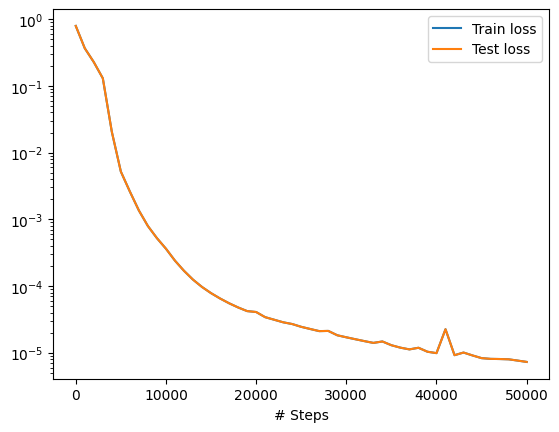

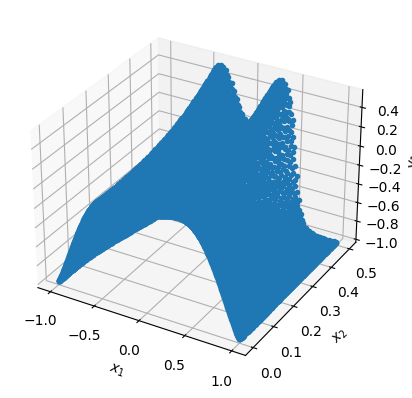

In [24]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [25]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

Mean residual: 2.0151124
L2 relative error: 0.3254830005489362


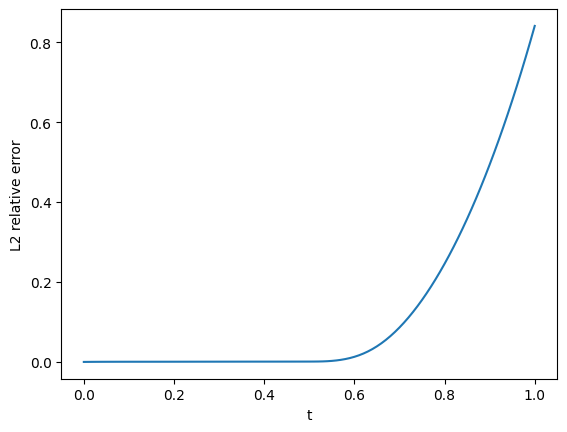

In [26]:
# compute the L2 relative error between the true solution and the predicted solution

rel_l2_errors = []

for i in range(0, 20200, 201):
    y_pred = model.predict(X[i:i+201])
    y_sol = y_true[i:i+201]

    # collect the relative L2 errors in a list
    rel_l2_errors.append(dde.metrics.l2_relative_error(y_sol, y_pred))


# plot the relative L2 errors

x = np.linspace(0, 1, 101)
plt.plot(x, rel_l2_errors)
plt.xlabel("t")
plt.ylabel("L2 relative error")
plt.show()

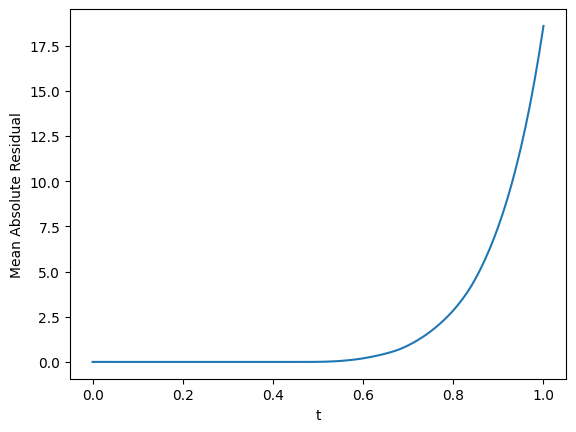

In [27]:
# compute the absolute residuals

absolute_residual = []

for i in range(0, 20200, 201):
    absolute_residual.append(np.mean(np.absolute(f)[i:i+201]))


# plot the relative absolute residuals

x = np.linspace(0, 1, 101)
plt.plot(x, absolute_residual)
plt.xlabel("t")
plt.ylabel("Mean Absolute Residual")
plt.show()

In [14]:
zero_predictions = [] # actually evaluations of the model at t = 0.1 ...
half_predictions = []
one_predictions = []

In [15]:
for i in range(5):
    model.train(iterations=10000)

    x = geom.uniform_points(201, True)
    t = np.full(201, 0.1)
    x = np.hstack((x, t.reshape(-1, 1)))
    y = model.predict(x)
    zero_predictions.append(y)

    x = geom.uniform_points(201, True)
    t = np.full(201, 0.5)
    x = np.hstack((x, t.reshape(-1, 1)))
    y = model.predict(x)
    half_predictions.append(y)

    x = geom.uniform_points(201, True)
    t = np.full(201, 1.0)
    x = np.hstack((x, t.reshape(-1, 1)))
    y = model.predict(x)
    one_predictions.append(y)

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [7.98e-01]    [7.98e-01]    []  
1000      [4.43e-01]    [4.43e-01]    []  
2000      [1.98e-01]    [1.98e-01]    []  
3000      [1.23e-01]    [1.23e-01]    []  
4000      [1.83e-02]    [1.83e-02]    []  
5000      [3.85e-03]    [3.85e-03]    []  
6000      [1.73e-03]    [1.73e-03]    []  
7000      [1.00e-03]    [1.00e-03]    []  
8000      [6.17e-04]    [6.17e-04]    []  
9000      [3.98e-04]    [3.98e-04]    []  
10000     [2.76e-04]    [2.76e-04]    []  

Best model at step 10000:
  train loss: 2.76e-04
  test loss: 2.76e-04
  test metric: []

'train' took 31.718273 s

Training model...

Step      Train loss    Test loss     Test metric
10000     [2.76e-04]    [2.76e-04]    []  
11000     [2.10e-04]    [2.10e-04]    []  
12000     [1.76e-04]    [1.76e-04]    []  
13000     [1.42e-04]    [1.42e-04]    []  
14000     [1.24e-04]    [1.24e-04]    []  
15000     [1.08e-04]    [1.08e-

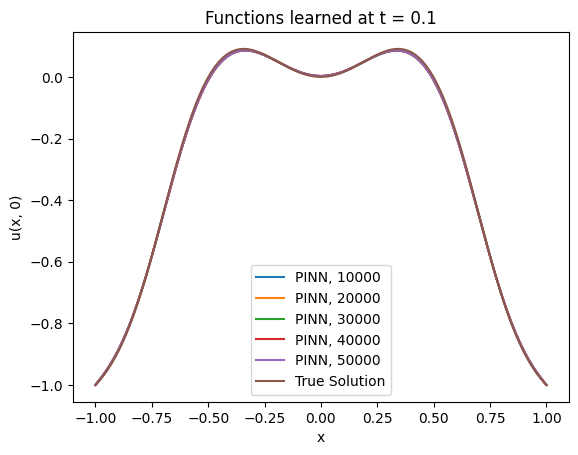

In [16]:
# plot the solution and compare it to the true solution

for i in range(len(zero_predictions)):
    plt.plot(np.linspace(-1, 1, 201), zero_predictions[i][:, 0], label="PINN, " + str((i+1) * 10000))

plt.plot(np.linspace(-1, 1, 201), y_true[2010:2211], label="True Solution")
plt.legend()
plt.title("Functions learned at t = 0.1")
plt.xlabel("x")
plt.ylabel("u(x, 0)")
plt.show()

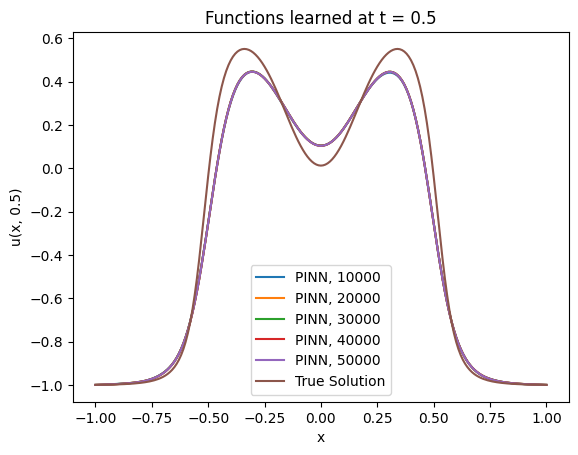

In [17]:
# plot the solution and compare it to the true solution

for i in range(len(zero_predictions)):
    plt.plot(np.linspace(-1, 1, 201), half_predictions[i][:, 0], label="PINN, " + str((i+1) * 10000))

plt.plot(np.linspace(-1, 1, 201), y_true[10050:10251], label="True Solution")
plt.legend()
plt.title("Functions learned at t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x, 0.5)")
plt.show()

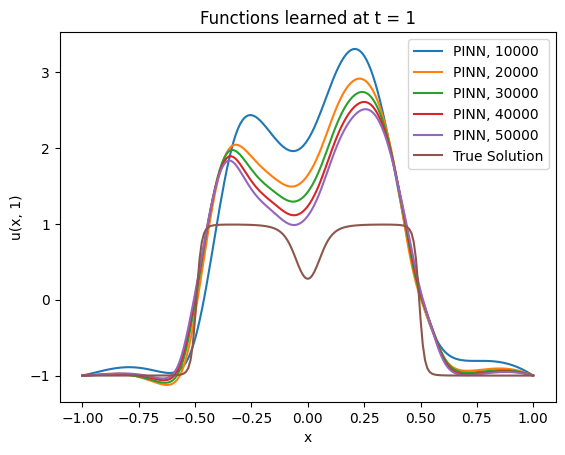

In [ ]:
# plot the solution and compare it to the true solution

for i in range(len(zero_predictions)):
    plt.plot(np.linspace(-1, 1, 201), one_predictions[i][:, 0], label="PINN, " + str((i+1) * 10000))

plt.plot(np.linspace(-1, 1, 201), y_true[20100:20301], label="True Solution")
plt.legend()
plt.title("Functions learned at t = 1")
plt.xlabel("x")
plt.ylabel("u(x, 1)")
plt.show()

In [ ]:
mean_residual_inter = []
mean_residual_extra = []

l2_error_inter = []
l2_error_extra = []

In [ ]:
# record mean residuals and l2-residuals over training epochs for t in [0, 1]

for i in range(30):
    model.train(iterations=1000)

    y_pred = model.predict(X)
    f = model.predict(X, operator=pde)

    mean_residual_inter.append(np.mean(np.absolute(f)[:10050]))
    l2_error_inter.append(dde.metrics.l2_relative_error(y_true[:10050], y_pred[:10050]))

    mean_residual_extra.append(np.mean(np.absolute(f)[10050:]))
    l2_error_extra.append(dde.metrics.l2_relative_error(y_true[10050:], y_pred[10050:]))

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [7.37e-01]    [7.37e-01]    []  
1000      [9.23e-03]    [9.23e-03]    []  

Best model at step 1000:
  train loss: 9.23e-03
  test loss: 9.23e-03
  test metric: []

'train' took 14.863271 s

Training model...

Step      Train loss    Test loss     Test metric
1000      [9.23e-03]    [9.23e-03]    []  
2000      [3.45e-03]    [3.45e-03]    []  

Best model at step 2000:
  train loss: 3.45e-03
  test loss: 3.45e-03
  test metric: []

'train' took 8.081609 s

Training model...

Step      Train loss    Test loss     Test metric
2000      [3.45e-03]    [3.45e-03]    []  
3000      [1.20e-03]    [1.20e-03]    []  

Best model at step 3000:
  train loss: 1.20e-03
  test loss: 1.20e-03
  test metric: []

'train' took 8.201658 s

Training model...

Step      Train loss    Test loss     Test metric
3000      [1.20e-03]    [1.20e-03]    []  
4000      [6.14e-04]    [6.14e-04]    []  

Best mo

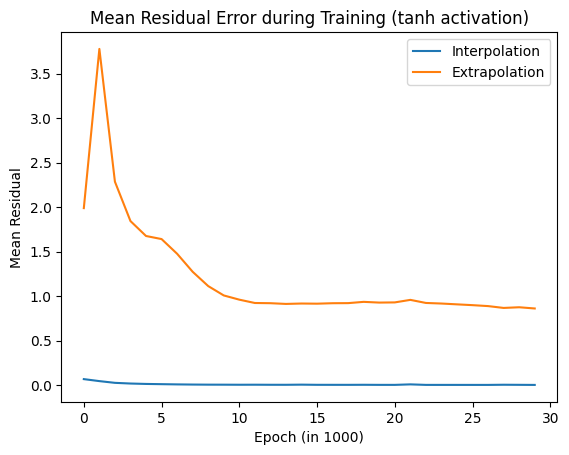

In [ ]:
# plot the mean residual in interpolation and extrapolation against the training epochs

plt.plot([*range(30)], mean_residual_inter, label="Interpolation")
plt.plot([*range(30)], mean_residual_extra, label="Extrapolation")

plt.legend()
plt.title("Mean Residual Error during Training (tanh activation)")
plt.xlabel("Epoch (in 1000)")
plt.ylabel("Mean Residual")
plt.show()

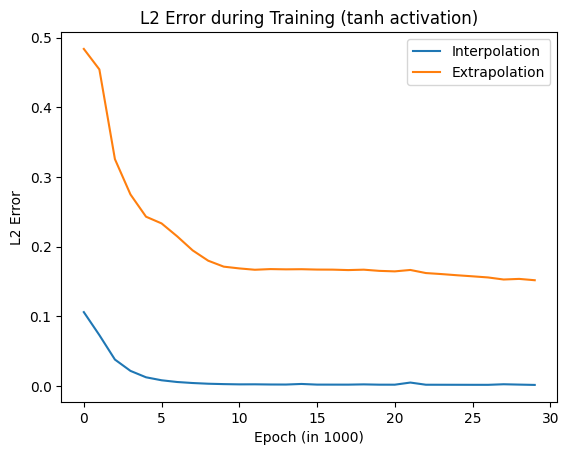

In [ ]:
# plot the mean residual in interpolation and extrapolation against the training epochs

plt.plot([*range(30)], l2_error_inter, label="Interpolation")
plt.plot([*range(30)], l2_error_extra, label="Extrapolation")

plt.legend()
plt.title("L2 Error during Training (tanh activation)")
plt.xlabel("Epoch (in 1000)")
plt.ylabel("L2 Error")
plt.show()